In [1]:
import h5py
import numpy as np
filename = "cowling_PSR+GW+NICER.h5"

mat = np.array([])

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    cowling_group_key = list(f.keys())[0]
    print(f[cowling_group_key])
    eos_keys = list(f[cowling_group_key].keys())
    eos_index = 47 # Warning: KEYS ARE NOT IN ORDER, 100th key will not be the 100th EOS
    print(f[cowling_group_key][eos_keys[eos_index]])
    data = f[cowling_group_key][eos_keys[eos_index]]
    print(data[()])
    M, R, f = data[()].T # has cgs units [grams, cm, Hz]
    temp = np.array([M, R, f])
    np.append(mat, temp)
    

Keys: <KeysViewHDF5 ['cowling']>
<HDF5 group "/cowling" (9929 members)>
<HDF5 dataset "eos_1040.csv": shape (53, 3), type "<f8">
[[4.97508387e+33 1.18100100e+06 2.42145476e+03]
 [4.97238745e+33 1.19150100e+06 2.40542543e+03]
 [4.96391081e+33 1.20170100e+06 2.39015494e+03]
 [4.94944837e+33 1.21150100e+06 2.37566023e+03]
 [4.92882282e+33 1.22110100e+06 2.36193103e+03]
 [4.90185103e+33 1.23020100e+06 2.34891811e+03]
 [4.86832861e+33 1.23880100e+06 2.33667860e+03]
 [4.82796834e+33 1.24690100e+06 2.32523658e+03]
 [4.78036814e+33 1.25430100e+06 2.31462095e+03]
 [4.72492553e+33 1.26100100e+06 2.30489529e+03]
 [4.66083715e+33 1.26690100e+06 2.29614926e+03]
 [4.58708780e+33 1.27190100e+06 2.28839011e+03]
 [4.50257184e+33 1.27600100e+06 2.28162426e+03]
 [4.40629878e+33 1.27900100e+06 2.27579461e+03]
 [4.29771063e+33 1.28090100e+06 2.27072080e+03]
 [4.17694700e+33 1.28170100e+06 2.26611481e+03]
 [4.04494213e+33 1.28150100e+06 2.26163871e+03]
 [3.90329902e+33 1.28050100e+06 2.25690184e+03]
 [3.754

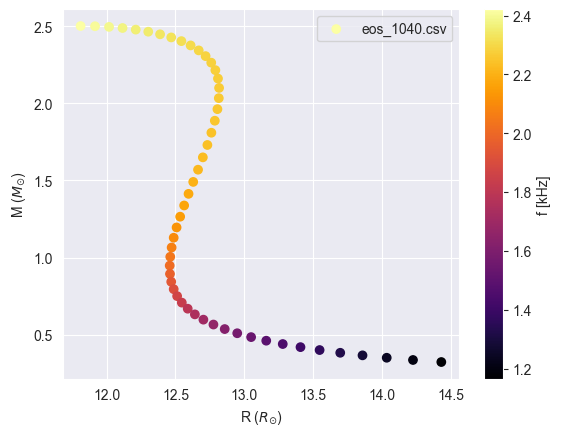

In [2]:
import matplotlib.pyplot as plt
plt.figure()

cm2km = 1e5 # cm [cgs]
Msun = 1.989e33 # g [cgs]

plt.scatter(R/cm2km, M/Msun, c = f/1000, cmap = "inferno", label = f"{eos_keys[eos_index]}")
cbar = plt.colorbar()
cbar.set_label("f [kHz]")
plt.xlabel(r"R ($R_{\odot}$)"); plt.ylabel(r"M ($M_{\odot}$)")
plt.legend()
plt.show()

In [3]:
from tqdm import tqdm

f = h5py.File(filename, "r") 
cowling_group_key = list(f.keys())[0]
eos_keys = list(f[cowling_group_key].keys())

mat = np.zeros([len(eos_keys), 3, 1000])
mat[:] = np.nan
mass_arr = np.array([])
radius_arr = np.array([])
freq_arr = np.array([])

for eos_index in tqdm(range(len(eos_keys))):
    data = f[cowling_group_key][eos_keys[eos_index]]
    M, R, f_mode = data[()].T # has cgs units [grams, cm, Hz]
    M = np.array(M)
    R = np.array(R)
    f_mode = np.array(f_mode)
    mat[eos_index, 0, :len(M)] = M
    mat[eos_index, 1, :len(R)] = R
    mat[eos_index, 2, :len(f_mode)] = f_mode
    mass_arr = np.append(mass_arr, M)
    radius_arr = np.append(radius_arr, R)
    freq_arr = np.append(freq_arr, f_mode)

100%|██████████| 9929/9929 [00:19<00:00, 500.89it/s] 


In [4]:
print(mass_arr.shape, radius_arr.shape, freq_arr.shape)
mass_arr = mass_arr/ Msun
mass_arr = mass_arr.squeeze()
radius_arr = radius_arr/ cm2km
radius_arr = radius_arr.squeeze()
freq_arr = freq_arr/1000
freq_arr = freq_arr.squeeze()

(529113,) (529113,) (529113,)


100%|██████████| 9929/9929 [00:18<00:00, 528.60it/s]


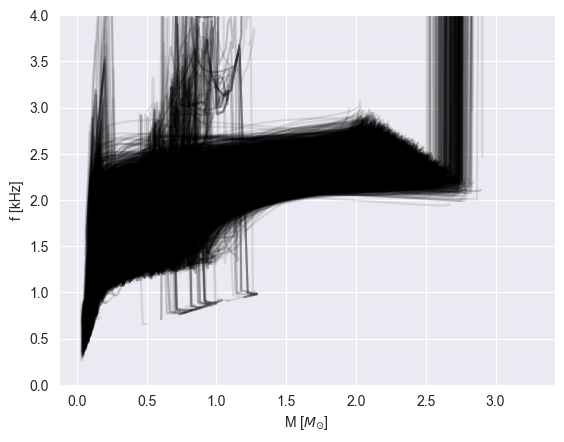

In [5]:
from scipy.interpolate import interp1d

global_m_min = mass_arr.min()
global_m_max = mass_arr.max()
n_len = 10000
m_interp_global = np.linspace(global_m_min + 0.01, global_m_max - 0.01, n_len) # Added small jitter for numerical stability
freq_interp_arr = np.zeros((len(eos_keys), n_len))
mass_interp_arr = np.zeros((len(eos_keys), n_len))

for i in tqdm(range(len(eos_keys))):
    M = mat[i, 0]/Msun
    f = mat[i, 2]/1000
    plt.plot(M, f, color = "black", alpha = 0.1)
    
    M = M[~np.isnan(M)]
    f = f[~np.isnan(f)]
    interpolator = interp1d(M, f, kind='cubic', fill_value="extrapolate")
    
    m_interp = m_interp_global.copy()
    m_interp[(m_interp <= M.min()) | (m_interp >= M.max())] = np.nan
    
    f_interp = interpolator(m_interp)
    freq_interp_arr[i] = f_interp
    mass_interp_arr[i] = m_interp
    
plt.ylim(0, 4)
plt.xlabel(r"M [$M_{\odot}$]"); plt.ylabel(r"f [kHz]")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

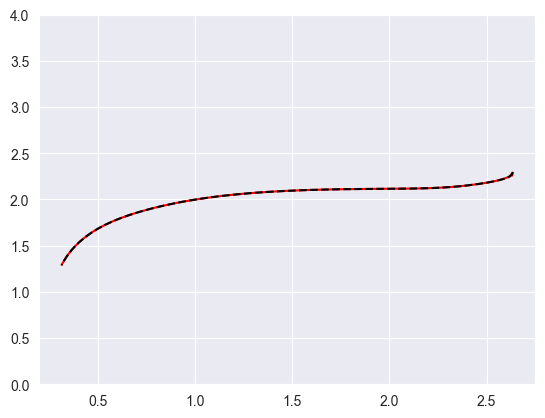

In [6]:
M = M[~np.isnan(M)]
f = f[~np.isnan(f)]
interpolator = interp1d(M, f, kind='cubic', fill_value="extrapolate")

m_interp = m_interp_global.copy()
m_interp[(m_interp <= M.min()) | (m_interp >= M.max())] = np.nan

f_interp = interpolator(m_interp)

plt.plot(m_interp, f_interp, color = "red")
plt.plot(M, f, linestyle = "dashed", color = "black")
plt.ylim(0, 4)
plt.show

In [9]:
freq_global_median = np.zeros(len(m_interp_global))
freq_global_025 = np.zeros(len(m_interp_global))
freq_global_975 = np.zeros(len(m_interp_global))

for i in tqdm(range(len(mass_interp_arr))): # Slicing across mass for all EOS here. 
    mass = mass_interp_arr[:,i]
    freq = freq_interp_arr[:,i] # fmode at that mass for all EOS
    
    mass = mass[~np.isnan(mass)]
    freq = freq[~np.isnan(freq)]
    
    mask2 = np.where(freq < 3.5)
    mass = mass[mask2]
    freq = freq[mask2]
    
    if len(mass) < 1:
        continue
    
    freq_global_median[i] = np.median(freq)
    freq_global_025[i] = np.quantile(freq, 0.05)
    freq_global_975[i] = np.quantile(freq, 0.95)

100%|██████████| 9929/9929 [00:15<00:00, 647.80it/s] 


(0.0, 4.0)

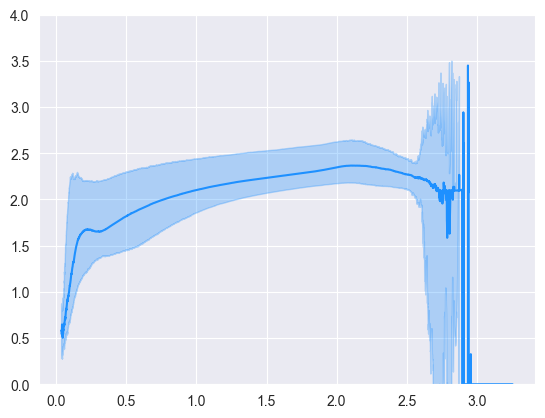

In [10]:
plt.plot(m_interp_global, freq_global_median, color='dodgerblue') 
plt.fill_between(m_interp_global, freq_global_025, freq_global_975, color='dodgerblue', alpha=0.3, label = "90% CI")
plt.ylim(0, 4)